In [1]:
# =========================
# BLOCK A — PREPROCESSING FOR GENE-SUMMED SNP DOSAGES
# =========================
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer

print("--- Starting Data Preprocessing (gene-summed SNP dosages) ---")

# --- File paths (your originals) ---
main_data_path    = '/Users/adithyamadduri/Downloads/all_chr_merged.parquet'
gwas_catalog_path = '/Users/adithyamadduri/Downloads/MONDO_0004975_associations_export.tsv'
string_links_path = '/Users/adithyamadduri/Downloads/9606.protein.links.v12.0.txt'      # unused here
string_info_path  = '/Users/adithyamadduri/Downloads/9606.protein.info.v12.0.txt'       # unused here

out_dir = "/Users/adithyamadduri/Desktop/Projects/Genomics_LGBM(Genomics+Meta)_RATIOS_fixed_rfe"
os.makedirs(out_dir, exist_ok=True)

# --- Load SNP matrix + GWAS mapping (your logic) ---
df = pd.read_parquet(main_data_path)
gwas_df = pd.read_csv(gwas_catalog_path, sep='\t')

gwas_df['riskAllele_cleaned'] = gwas_df['riskAllele'].astype(str).str.split('-').str[0].str.strip()
gwas_df['first_gene'] = gwas_df['mappedGenes'].astype(str).str.split(',').str[0].str.strip()
rs_map = gwas_df.dropna(subset=['riskAllele_cleaned', 'first_gene']) \
                .set_index('riskAllele_cleaned')['first_gene'].to_dict()

df.columns = [c.strip() for c in df.columns]
snp_cols = [c for c in df.columns if c.startswith('rs') or c.startswith('chr')]
all_mapped_snps = {s: rs_map.get(s.split('_')[0]) for s in snp_cols if rs_map.get(s.split('_')[0])}

# --- SNP QC (same thresholds as baseline) ---
print("\n--- SNP QC ---")
snps_to_map = list(all_mapped_snps.keys())
maf = df[snps_to_map].apply(
    lambda x: (2*x.eq(2).sum() + x.eq(1).sum()) / (2*x.notna().sum()),
    axis=0
)
snps_to_remove_maf = maf[maf < 0.01].index.tolist()

missing_rates = df[snps_to_map].isna().mean()
snps_to_remove_callrate = missing_rates[missing_rates > 0.05].index.tolist()

all_snps_to_remove = set(snps_to_remove_maf + snps_to_remove_callrate)
all_mapped_snps_qc = {snp: gene for snp, gene in all_mapped_snps.items() if snp not in all_snps_to_remove}

df_qc = df.drop(columns=list(all_snps_to_remove), errors="ignore")
snp_cols_qc = list(all_mapped_snps_qc.keys())
print(f"Retained {len(snp_cols_qc)} SNPs after QC.")

# --- Label assignment (your definitions) ---
print("\n--- Label assignment ---")
df_qc['age_death'] = pd.to_numeric(df_qc['age_death'].astype(str).replace('90+', '90', regex=False), errors='coerce')

conditions = [
    (df_qc['ceradsc'].isin([1, 2])) & (df_qc['cogdx'].isin([4, 5])),
    (df_qc['ceradsc'].isin([1, 2])) & ~(df_qc['cogdx'].isin([4, 5])),
    ~(df_qc['ceradsc'].isin([1, 2])) & (df_qc['cogdx'].isin([4, 5])),
    ~(df_qc['ceradsc'].isin([1, 2])) & ~(df_qc['cogdx'].isin([4, 5]))
]
choices = ['Typical AD', 'Resilient', 'Symptomatic Non-AD', 'Healthy Control']
df_qc['patient_group'] = np.select(conditions, choices, default='Unknown')
df_qc = df_qc[df_qc['patient_group'] != 'Unknown'].reset_index(drop=True)

print("Patient Group Counts:")
print(df_qc['patient_group'].value_counts())

# --- Demographics + SNP handling (mirror baseline) ---
numeric_features     = ['age_death', 'educ']
categorical_features = ['apoe_genotype']
binary_features      = ['msex']
snp_features         = snp_cols_qc

feature_df = df_qc[['projid'] + numeric_features + categorical_features + binary_features + snp_features].copy()

# Impute numeric only
imputer_num = SimpleImputer(strategy='median')
feature_df[numeric_features] = imputer_num.fit_transform(feature_df[numeric_features])

# Keep SNP NaNs; round observed to {0,1,2}
snp_block = feature_df[snp_features].astype(float)
mask = ~snp_block.isna()
rounded = np.empty_like(snp_block.values)
rounded[:] = np.nan
rounded[mask.values] = np.rint(snp_block.values[mask.values])
snp_block = pd.DataFrame(rounded, columns=snp_features, index=feature_df.index)
feature_df[snp_features] = snp_block

feature_df[binary_features] = feature_df[binary_features].astype(int)

# Sum SNPs → genes (ignore NaN; keep NaN if all missing)
print("\n--- Building gene-summed dosage matrix ---")
gene_to_snps = defaultdict(list)
for snp, gene in all_mapped_snps_qc.items():
    gene_to_snps[gene].append(snp)

gene_dosage_df = pd.DataFrame(index=feature_df.index)
for gene, snp_list in gene_to_snps.items():
    vals = feature_df[snp_list].to_numpy(dtype=float)
    gsum = np.nansum(vals, axis=1)
    all_missing = np.isnan(vals).all(axis=1)
    gsum[all_missing] = np.nan
    gene_dosage_df[gene] = gsum

# APOE OHE
try:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
except TypeError:
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
apoe_encoded = ohe.fit_transform(feature_df[['apoe_genotype']])
apoe_df = pd.DataFrame(apoe_encoded, columns=ohe.get_feature_names_out(), index=feature_df.index)

# Final feature table: demographics + APOE OHE + gene_sums
X_gene_based = pd.concat(
    [feature_df[numeric_features + binary_features].reset_index(drop=True),
     apoe_df.reset_index(drop=True),
     gene_dosage_df.reset_index(drop=True)],
    axis=1
)
X_gene_based.columns = X_gene_based.columns.astype(str)

# Labels & encoders (to match your baseline later)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_qc['patient_group'].astype(str).values)
y_labels = df_qc['patient_group'].astype(str).values

# Stratifier exactly like your baseline
y_strat = (df_qc['patient_group'].astype(str) + "_" + df_qc['msex'].astype(int).astype(str)).values

# Keep list of pure gene columns (for ratio generation later)
non_gene_cols = set(numeric_features + binary_features + list(apoe_df.columns))
gene_cols = [c for c in X_gene_based.columns if c not in non_gene_cols]

# Groups
groups = df_qc['projid'].astype(str).values

print(f"\nX_gene_based shape: {X_gene_based.shape}")
print("Label to Class Name mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{i}: {class_name}")
print(f"Total genes available for ratio generation: {len(gene_cols)}")

--- Starting Data Preprocessing (gene-summed SNP dosages) ---

--- SNP QC ---
Retained 445 SNPs after QC.

--- Label assignment ---
Patient Group Counts:
patient_group
Healthy Control       353
Typical AD            223
Resilient             179
Symptomatic Non-AD     56
Name: count, dtype: int64

--- Building gene-summed dosage matrix ---

X_gene_based shape: (811, 360)
Label to Class Name mapping:
0: Healthy Control
1: Resilient
2: Symptomatic Non-AD
3: Typical AD
Total genes available for ratio generation: 350


/var/folders/yr/4bplyc1x1tq4xz4jckbg_8wr0000gn/T/ipykernel_22703/5895829.py:106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gene_dosage_df[gene] = gsum
/var/folders/yr/4bplyc1x1tq4xz4jckbg_8wr0000gn/T/ipykernel_22703/5895829.py:106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gene_dosage_df[gene] = gsum
/var/folders/yr/4bplyc1x1tq4xz4jckbg_8wr0000gn/T/ipykernel_22703/5895829.py:106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

In [2]:
# =========================
# BLOCK B — READ BASELINE GENOMICS PICKLES & COLLECT STABLE GENES
# =========================
import os, pickle
from collections import Counter, defaultdict

print("\n--- Reading baseline GENOMICS LGBM pickles for stable features (≥2/5 seeds) ---")

baseline_models_dir = "/Users/adithyamadduri/Desktop/Projects/ml4h_project/LGBM(Genes+Demo)"

# Match EXACT names you saved with in baseline training
classes = [
    "Healthy_Control",
    "Resilient",
    "Symptomatic_Non-AD",
    "Typical_AD"
]
seeds = [1, 2, 3, 4, 5]

def _get_trained_estimator_and_features(automl_obj):
    model = getattr(automl_obj, "model", None)
    est = getattr(model, "estimator", model)
    if est is None:
        return None, None
    if hasattr(automl_obj, "feature_names_in_") and automl_obj.feature_names_in_ is not None:
        feat_names = list(automl_obj.feature_names_in_)
    elif hasattr(est, "feature_name_") and est.feature_name_ is not None:
        feat_names = list(est.feature_name_)
    else:
        feat_names = None
    return est, feat_names

feature_counts_per_class = defaultdict(Counter)

for seed in seeds:
    for cls in classes:
        pkl_path = os.path.join(baseline_models_dir, f"seed{seed}_{cls}_automl.pkl")
        if not os.path.exists(pkl_path):
            print(f"[WARN] Missing: {pkl_path}")
            continue
        try:
            with open(pkl_path, "rb") as f:
                automl = pickle.load(f)
            est, feature_names = _get_trained_estimator_and_features(automl)
            if est is None or not hasattr(est, "feature_importances_"):
                print(f"[WARN] No feature importances in {pkl_path}")
                continue
            importances = est.feature_importances_
            nonzero_genes = [f for f, imp in zip(feature_names, importances) if imp > 0 and f in gene_cols]
            feature_counts_per_class[cls].update(nonzero_genes)
        except Exception as e:
            print(f"[ERROR] {pkl_path}: {e}")

# keep genes seen in ≥2 seeds
shared_features_per_class = {
    cls: [feat for feat, cnt in cnts.items() if cnt >= 2]
    for cls, cnts in feature_counts_per_class.items()
}

for cls in classes:
    feats = shared_features_per_class.get(cls, [])
    print(f"[{cls}] Stable genes (≥2 seeds): {len(feats)}")


--- Reading baseline GENOMICS LGBM pickles for stable features (≥2/5 seeds) ---
[Healthy_Control] Stable genes (≥2 seeds): 7
[Resilient] Stable genes (≥2 seeds): 23
[Symptomatic_Non-AD] Stable genes (≥2 seeds): 49
[Typical_AD] Stable genes (≥2 seeds): 7


In [3]:
# =========================
# BLOCK C — RATIO TRAINING WITH RFE (GENE-BASED) - CORRECTED
# =========================

import os
out_dir = "/Users/adithyamadduri/Desktop/Projects/Genomics_LGBM(Genomics+Meta)_RATIOS_Demo"
os.makedirs(out_dir, exist_ok=True)


import os
import numpy as np
import pandas as pd
from itertools import combinations
from flaml import AutoML
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE
from lightgbm import LGBMClassifier

# ---- Config (assumes variables from Blocks A & B are loaded) ----
# `out_dir`, `label_encoder`, `y_labels`, `y_strat`, `groups`,
# `X_gene_based`, `gene_cols`, and `shared_features_per_class`
# should all be available from the previous blocks.

# --- 💡 FIX: Use the class names with underscores to match the keys ---
# --- in the `shared_features_per_class` dictionary from Block B. ---
classes = [
    "Healthy_Control",
    "Resilient",
    "Symptomatic_Non-AD",
    "Typical_AD"
]
seeds = [1, 2, 3, 4, 5]

def safe_cls(c):
    return c.replace(" ", "_").replace("/", "-")

# ---- Gene-only matrix for creating ratios ----
X_genes_only = X_gene_based[gene_cols].copy()

# >>> ADDED: demographics + APOE OHE column list (not used in RFE)
demo_base = ['age_death', 'educ', 'msex']
apoe_cols = [c for c in X_gene_based.columns if c.startswith('apoe_genotype_')]
demo_cols = demo_base + apoe_cols

# ---- Custom group-aware stratified split function (no changes needed) ----
def group_stratified_shuffle_split(df_index, strata_all, groups_all, test_size=0.30, random_state=0):
    rng = np.random.RandomState(random_state)
    data = pd.DataFrame({"idx": df_index, "strata": strata_all, "group": groups_all})
    grp_mode = data.groupby("group")["strata"].agg(lambda s: s.value_counts().idxmax())
    grp_mode = grp_mode.sample(frac=1.0, random_state=random_state)

    train_groups, test_groups = [], []
    for _, grp_ids in grp_mode.groupby(grp_mode.values):
        g_list = list(grp_ids.index)
        rng.shuffle(g_list)
        n_test = max(1, int(round(test_size * len(g_list))))
        test_groups.extend(g_list[:n_test])
        train_groups.extend(g_list[n_test:])

    train_mask = np.isin(groups_all, train_groups)
    test_mask  = np.isin(groups_all, test_groups)
    return np.where(train_mask)[0], np.where(test_mask)[0]

# ---- Main Training Loop ----
for cls in classes:
    # 1. Select stable genes for the current class
    # Now, `cls` will be "Healthy_Control", which correctly finds the 7 genes.
    class_genes = shared_features_per_class.get(cls, [])
    print(f"\n[{cls}] Using {len(class_genes)} stable genes for ratio generation...")

    if len(class_genes) < 2:
        print(f"-> Skipping [{cls}]: Not enough genes to form ratios (need at least 2).")
        continue

    # 2. Generate all pairwise ratios from the selected genes
    ratio_cols = []
    ratio_data = []
    epsilon = 1e-8  # Small value to prevent division by zero

    for g1, g2 in combinations(class_genes, 2):
        rname = f"{g1}_div_{g2}"
        ratio_cols.append(rname)
        # Add epsilon for numerical stability
        ratio_data.append(X_genes_only[g1].values / (X_genes_only[g2].values + epsilon))

    X_ratio_cls = pd.DataFrame(np.column_stack(ratio_data), columns=ratio_cols, index=X_genes_only.index)
    print(f"-> Generated {X_ratio_cls.shape[1]} ratio features for [{cls}].")

    # 3. Loop through seeds to perform train/test split, RFE, and model training
    for seed in seeds:
        # A. Split data into training and testing sets
        tr_idx, te_idx = group_stratified_shuffle_split(
            df_index=np.arange(len(X_ratio_cls)),
            strata_all=y_strat,
            groups_all=groups,
            test_size=0.30,
            random_state=seed,
        )

        # B. Create initial data splits with all generated ratios
        X_train_full = X_ratio_cls.iloc[tr_idx]
        X_test_full  = X_ratio_cls.iloc[te_idx]
        y_train_full = pd.Series(y_labels).iloc[tr_idx].values
        y_test_full  = pd.Series(y_labels).iloc[te_idx].values

        print(f"[{cls} | Seed {seed}] Train/Test split: {len(tr_idx)} / {len(te_idx)}")

        # C. Create binary labels for one-vs-all classification
        # We must convert the underscore version back to the space version to match `y_labels`
        y_train = (y_train_full == cls.replace("_", " ")).astype(int)
        y_test  = (y_test_full == cls.replace("_", " ")).astype(int)


        # D. Perform RFE on the TRAINING data ONLY
        rfe_model = LGBMClassifier(n_estimators=100, random_state=seed)
        n_select  = min(100, X_train_full.shape[1]) # Select up to 100 features
        rfe = RFE(estimator=rfe_model, n_features_to_select=n_select, step=0.1)
        rfe.fit(X_train_full, y_train)

        # E. Filter both train and test sets using the features selected by RFE
        selected_cols = list(X_train_full.columns[rfe.get_support()])
        X_train = X_train_full[selected_cols]
        X_test  = X_test_full[selected_cols]
        print(f"-> Post-RFE features selected: {len(selected_cols)}")

        X_train = pd.concat([X_train, X_gene_based.loc[X_train.index, demo_cols]], axis=1)
        X_test  = pd.concat([X_test,  X_gene_based.loc[X_test.index,  demo_cols]], axis=1)

        # F. Train the final model using AutoML
        automl = AutoML()
        settings = {
            "time_budget": 100,
            "metric": "roc_auc",
            "task": "classification",
            "eval_method": "cv",
            "estimator_list": ["lgbm"],
            "log_file_name": os.path.join(out_dir, f"flaml_seed{seed}_{safe_cls(cls)}.log"),
            "seed": seed,
        }

        automl.fit(X_train=X_train, y_train=y_train, **settings)
        automl.pickle(os.path.join(out_dir, f"seed{seed}_{safe_cls(cls)}_automl.pkl"))

        # G. Evaluate performance and save results
        y_score = automl.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_score) if (y_test.sum() > 0 and y_test.sum() < len(y_test)) else float("nan")
        print(f"  -> FINAL AUC = {auc:.4f}\n")

        out_csv = os.path.join(out_dir, f"seed{seed}_{safe_cls(cls)}.csv")
        pd.DataFrame({
            "y_true": y_test.astype(int),
            "y_score": y_score.astype(float)
        }).to_csv(out_csv, index=False)


[Healthy_Control] Using 7 stable genes for ratio generation...
-> Generated 21 ratio features for [Healthy_Control].
[Healthy_Control | Seed 1] Train/Test split: 567 / 244
[LightGBM] [Info] Number of positive: 247, number of negative: 320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 567, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.435626 -> initscore=-0.258933
[LightGBM] [Info] Start training from score -0.258933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Saved plot to: /Users/adithyamadduri/Desktop/Projects/Genomics_LGBM(Genomics+Meta)_RATIOS_Demo/roc_mean_across_seeds.png
Saved AUC summary to: /Users/adithyamadduri/Desktop/Projects/Genomics_LGBM(Genomics+Meta)_RATIOS_Demo/roc_auc_summary.csv
             Class  Mean_AUC  Std_AUC  N
   Healthy Control  0.824378 0.018480  5
         Resilient  0.691618 0.035008  5
Symptomatic Non-AD  0.599093 0.047993  5
        Typical AD  0.764753 0.019860  5


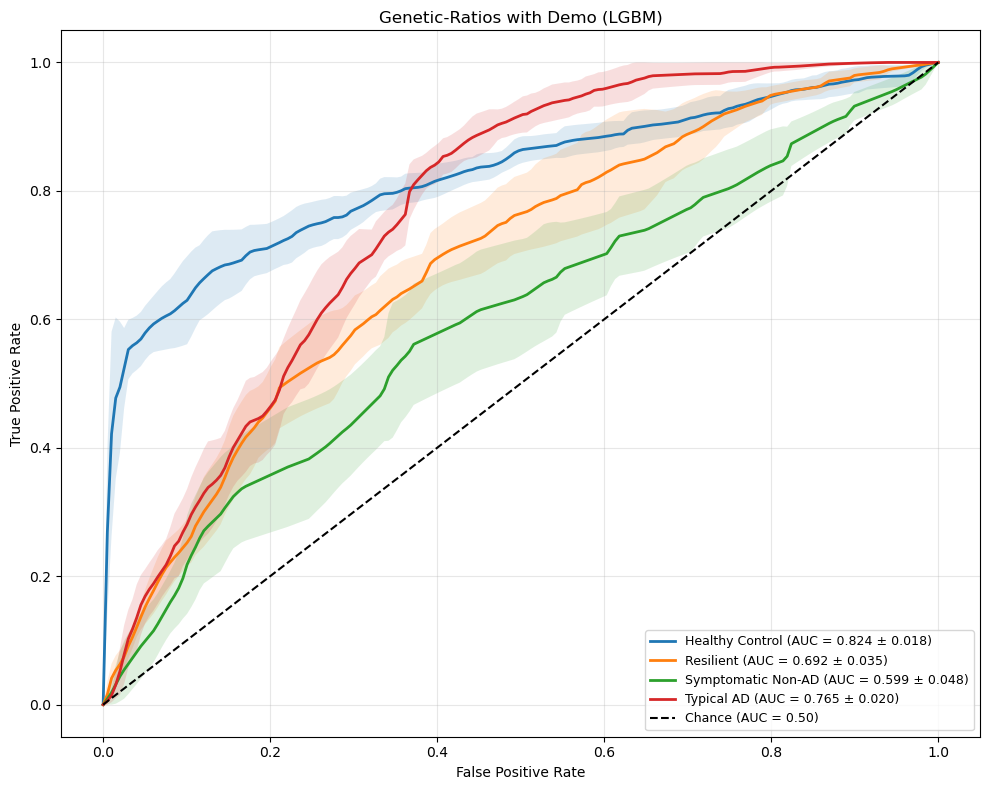

In [8]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ==== CONFIG ====
folder = "/Users/adithyamadduri/Desktop/Projects/Genomics_LGBM(Genomics+Meta)_RATIOS_Demo"

# ---- Collect CSVs (pattern: seed{seed}_{Class}.csv) ----
files = glob.glob(os.path.join(folder, "seed*_*/*.csv"))  # if you saved in subfolders; else:
if not files:
    files = glob.glob(os.path.join(folder, "seed*_*.csv"))

def class_from_path(p):
    base = os.path.basename(p)
    # handles: seed5_Typical_AD.csv  OR seed5_Typical_AD_plus_something.csv
    return "_".join(base.split("_")[1:]).rsplit(".csv", 1)[0]

class_names = sorted(set(class_from_path(p) for p in files))

# ==== Plot ====
fpr_grid = np.linspace(0.0, 1.0, 200)
plt.figure(figsize=(10, 8))

auc_summary_rows = []

for cls in class_names:
    cls_files = sorted(glob.glob(os.path.join(folder, f"seed*_{cls}.csv")))
    if not cls_files:
        continue

    tprs_interp, aucs = [], []

    for path in cls_files:
        df = pd.read_csv(path)
        y_true = df["y_true"].astype(int).values
        y_score = df["y_score"].astype(float).values

        # guard against degenerate splits
        if y_true.sum() == 0 or y_true.sum() == len(y_true):
            continue

        fpr, tpr, _ = roc_curve(y_true, y_score)

        # ensure strictly increasing FPR for interpolation
        uniq_idx = np.unique(fpr, return_index=True)[1]
        fpr_u = fpr[uniq_idx]
        tpr_u = tpr[uniq_idx]

        # interpolate on common grid
        tpr_i = np.interp(fpr_grid, fpr_u, tpr_u)
        tpr_i[0] = 0.0
        tpr_i[-1] = 1.0
        tprs_interp.append(tpr_i)

        aucs.append(auc(fpr_u, tpr_u))

    if not tprs_interp:
        print(f"[WARN] No valid ROC curves for class {cls} (all-positive or all-negative splits?)")
        continue

    mean_tpr = np.mean(tprs_interp, axis=0)
    std_tpr  = np.std(tprs_interp, axis=0)
    mean_auc = float(np.mean(aucs))
    std_auc  = float(np.std(aucs))

    # pretty label
    label_cls = cls.replace("_", " ")
    plt.plot(fpr_grid, mean_tpr, lw=2,
             label=f"{label_cls} (AUC = {mean_auc:.3f} ± {std_auc:.3f})")
    plt.fill_between(fpr_grid,
                     np.clip(mean_tpr - std_tpr, 0, 1),
                     np.clip(mean_tpr + std_tpr, 0, 1),
                     alpha=0.15)

    auc_summary_rows.append({"Class": label_cls, "Mean_AUC": mean_auc, "Std_AUC": std_auc, "N": len(aucs)})

# chance line
plt.plot([0, 1], [0, 1], "k--", label="Chance (AUC = 0.50)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Genetic-Ratios with Demo (LGBM)")
plt.legend(loc="lower right", fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# optional: save figure and AUC table
plot_path = os.path.join(folder, "roc_mean_across_seeds.png")
plt.savefig(plot_path, dpi=200)
print(f"Saved plot to: {plot_path}")

if auc_summary_rows:
    auc_df = pd.DataFrame(auc_summary_rows).sort_values("Class")
    auc_csv = os.path.join(folder, "roc_auc_summary.csv")
    auc_df.to_csv(auc_csv, index=False)
    print(f"Saved AUC summary to: {auc_csv}")
    print(auc_df.to_string(index=False))

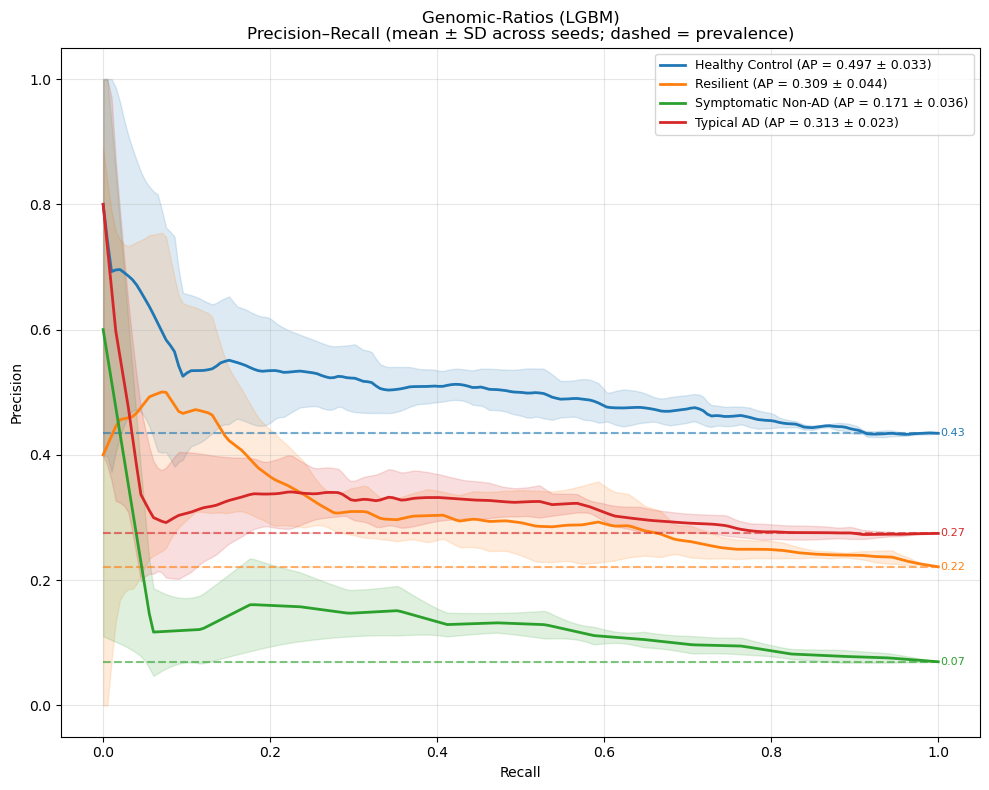

In [21]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# ====== CONFIG ======
folder = "/Users/adithyamadduri/Desktop/Projects/Genomics_LGBM(Genomics+Meta)_RATIOS_fixed_rfe"

def class_from_path(p):
    base = os.path.basename(p)
    return "_".join(base.split("_")[1:]).rsplit(".csv", 1)[0]

files = glob.glob(os.path.join(folder, "seed*_*.csv"))
class_names = sorted(set(class_from_path(p) for p in files))

recall_grid = np.linspace(0.0, 1.0, 200)

plt.figure(figsize=(10, 8))

for cls in class_names:
    cls_files = sorted(glob.glob(os.path.join(folder, f"seed*_{cls}.csv")))
    if not cls_files:
        print(f"[warn] No CSVs found for class={cls}")
        continue

    prec_interp_list, aps = [], []
    prevalences = []  # for PR baseline

    for path in cls_files:
        df = pd.read_csv(path)
        y_true  = df["y_true"].astype(int).values
        y_score = df["y_score"].astype(float).values

        # --- PR curve ---
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        # Deduplicate recall for interpolation
        uniq_idx = np.unique(recall, return_index=True)[1]
        r_u, p_u = recall[uniq_idx], precision[uniq_idx]

        # Interpolate precision onto a common recall grid
        p_i = np.interp(recall_grid, r_u, p_u, left=p_u[0], right=p_u[-1])
        prec_interp_list.append(p_i)

        # Average Precision and prevalence (positive rate) for baseline
        aps.append(average_precision_score(y_true, y_score))
        prevalences.append(y_true.mean())

    if not prec_interp_list:
        continue

    mean_prec = np.mean(prec_interp_list, axis=0)
    std_prec  = np.std(prec_interp_list, axis=0)
    mean_ap   = float(np.mean(aps))
    std_ap    = float(np.std(aps))

    # Plot PR curve (mean ± SD)
    line, = plt.plot(recall_grid, mean_prec, lw=2,
                     label=f"{cls.replace('_',' ')} (AP = {mean_ap:.3f} ± {std_ap:.3f})")
    plt.fill_between(recall_grid,
                     np.clip(mean_prec - std_prec, 0, 1),
                     np.clip(mean_prec + std_prec, 0, 1),
                     alpha=0.15, color=line.get_color())

    # --- Add class-specific PR baseline (chance level = prevalence) ---
    prev_mean = float(np.mean(prevalences))
    prev_sd   = float(np.std(prevalences))
    # dashed baseline
    plt.hlines(prev_mean, 0, 1, colors=line.get_color(), linestyles="--", alpha=0.6)
    # light band for ±1 SD
    low = max(0.0, prev_mean - prev_sd)
    high = min(1.0, prev_mean + prev_sd)
    plt.fill_between([0, 1], [low, low], [high, high],
                     color=line.get_color(), alpha=0.08)

    # Add a tiny annotation so readers know the baseline value
    plt.text(1.002, prev_mean, f"{prev_mean:.2f}",
             color=line.get_color(), va="center", fontsize=8)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Genomic-Ratios (LGBM)\nPrecision–Recall (mean ± SD across seeds; dashed = prevalence)")
plt.legend(loc='upper right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

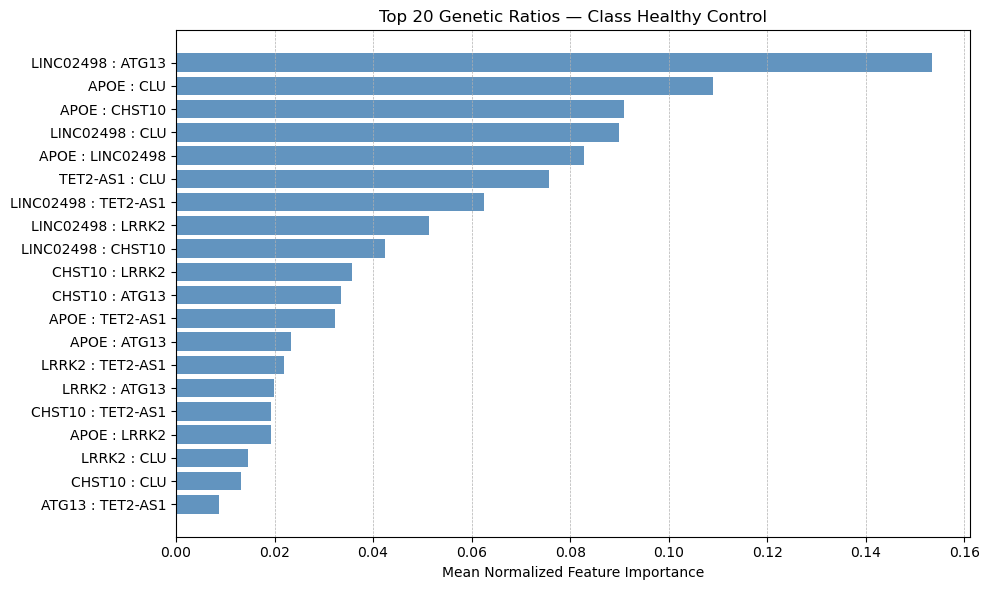

Saved: /Users/adithyamadduri/Desktop/Projects/Genomics_LGBM(Genomics+Meta)_RATIOS_fixed_rfe/top20_ratios_Healthy_Control.png


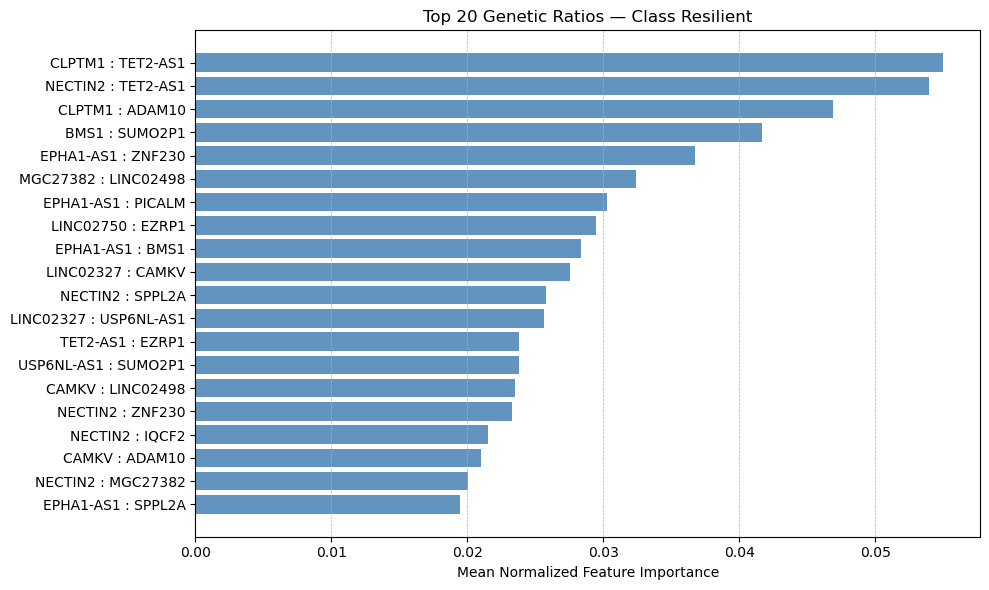

Saved: /Users/adithyamadduri/Desktop/Projects/Genomics_LGBM(Genomics+Meta)_RATIOS_fixed_rfe/top20_ratios_Resilient.png


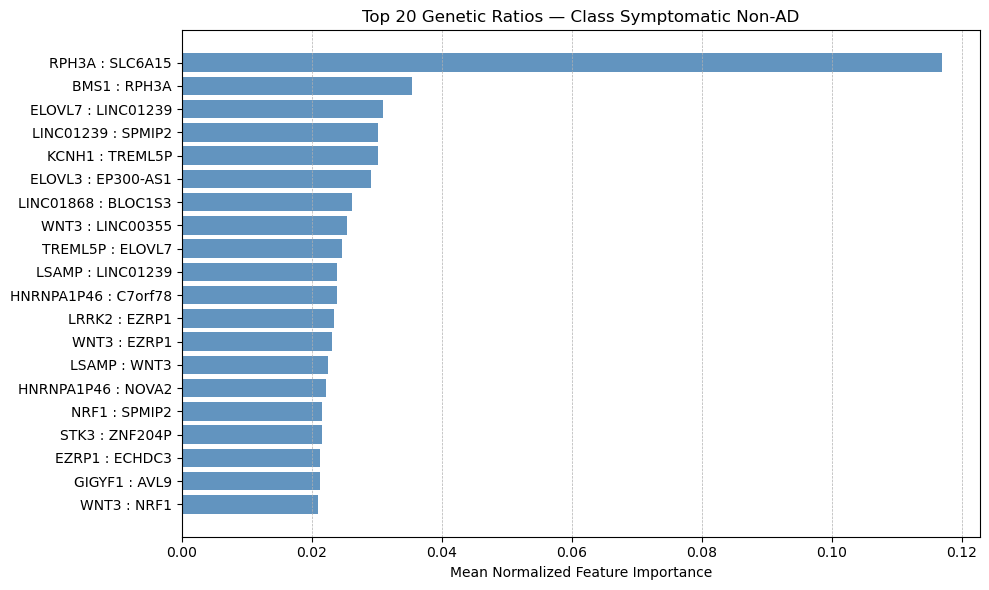

Saved: /Users/adithyamadduri/Desktop/Projects/Genomics_LGBM(Genomics+Meta)_RATIOS_fixed_rfe/top20_ratios_Symptomatic_Non-AD.png


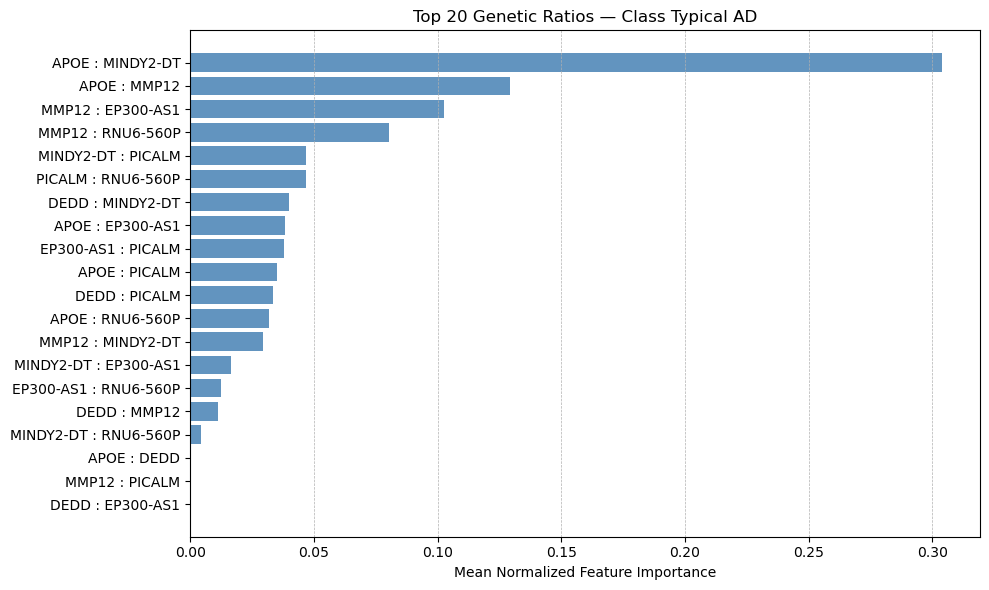

Saved: /Users/adithyamadduri/Desktop/Projects/Genomics_LGBM(Genomics+Meta)_RATIOS_fixed_rfe/top20_ratios_Typical_AD.png


In [20]:
# =========================
# FEATURE IMPORTANCE PLOTS (GENE RATIOS)
# =========================
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === CONFIG ===
out_dir = "/Users/adithyamadduri/Desktop/Projects/Genomics_LGBM(Genomics+Meta)_RATIOS_fixed_rfe"   # same folder where your ratio models were saved
classes = list(label_encoder.classes_)    # e.g., ["Healthy Control", "Resilient", ...]
seeds   = [1, 2, 3, 4, 5]
top_n   = 20  # number of top features to display

def safe_cls(c):
    return c.replace("+", "plus").replace(" ", "_").replace("/", "-")
# === MAIN LOOP ===

for cls in classes:
    feature_importance_list = []

    for seed in seeds:
        pkl_path = os.path.join(out_dir, f"seed{seed}_{safe_cls(cls)}_automl.pkl")
        if not os.path.exists(pkl_path):
            print(f"Missing: {pkl_path}")
            continue

        with open(pkl_path, "rb") as f:
            automl = pickle.load(f)

        model = automl.model.estimator
        importances = model.feature_importances_
        features = automl.feature_names_in_

        # Normalize importance
        norm_importance = importances / importances.sum()
        feature_importance_list.append(pd.Series(norm_importance, index=features))

    if not feature_importance_list:
        print(f"No data for class: {cls}")
        continue

    # Combine across seeds
    df_importances = pd.concat(feature_importance_list, axis=1)
    df_importances.columns = [f"seed{i}" for i in range(len(df_importances.columns))]

    # Compute mean across seeds
    df_importances["mean"] = df_importances.mean(axis=1)

    # Take top N
    df_top = df_importances.sort_values("mean", ascending=False).head(top_n)

    # Replace "_div_" with " : "
    df_top["mapped_name"] = df_top.index.str.replace("_div_", " : ")

    # === Plot ===
    plt.figure(figsize=(10, max(6, 0.3 * top_n)))
    plt.barh(y=df_top["mapped_name"][::-1], width=df_top["mean"][::-1], color="steelblue", alpha=0.85)

    plt.xlabel("Mean Normalized Feature Importance")
    plt.title(f"Top {top_n} Genetic Ratios — Class {cls}")
    plt.tight_layout()
    plt.grid(True, axis="x", linestyle="--", linewidth=0.5)

    # Save plot
    plot_path = os.path.join(out_dir, f"top{top_n}_ratios_{safe_cls(cls)}.png")
    plt.savefig(plot_path, dpi=300)
    plt.show()

    print(f"Saved: {plot_path}")